# ML Model for Groundwater detection based on resistivity values

# Step 0. Import Dependencies

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from flask import Flask, request, jsonify
from sklearn.pipeline import Pipeline

# Step 1. Load and pre-process dataset

In [2]:
inputfile = 'EL EDEN_TOMO-01.csv'
raw_data = pd.read_csv(inputfile, delimiter= ',')  # Adjust delimiter if needed
print(raw_data.head(100))

    elec_pos  depth      rho      cond
0       0.75  0.375   25.550  0.039100
1       2.25  0.375   21.047  0.047500
2       3.75  0.375  177.340  0.005639
3       5.25  0.375   88.893  0.011200
4       6.75  0.375   65.648  0.015200
..       ...    ...      ...       ...
95     23.25  1.125   85.276  0.011700
96     24.75  1.125   65.016  0.015400
97     26.25  1.125   61.697  0.016200
98     27.75  1.125   97.625  0.010200
99     29.25  1.125   54.441  0.018400

[100 rows x 4 columns]


Define rho thereshold and add a new column to define groundwater presence

In [3]:
rho_threshold = 50
raw_data['groundwater_presence'] = (raw_data['rho'] < rho_threshold).astype(int)

Correlation Analysis

In [4]:
correlation_matrix = raw_data.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Check for correlation > 0.7
highly_correlated = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            col_i = correlation_matrix.columns[i]
            col_j = correlation_matrix.columns[j]
            highly_correlated.append((col_i, col_j))
print("Highly Correlated Features:", highly_correlated)

# Remove explanatory variables of the basis
features_to_remove = ['elec_pos']  # Add more features if needed
raw_data_filtered = raw_data.drop(columns=features_to_remove)

Correlation Matrix:
                           elec_pos         depth       rho      cond  \
elec_pos              1.000000e+00 -1.005993e-16  0.016794  0.074310   
depth                -1.005993e-16  1.000000e+00 -0.122715  0.225429   
rho                   1.679380e-02 -1.227151e-01  1.000000 -0.104366   
cond                  7.430999e-02  2.254286e-01 -0.104366  1.000000   
groundwater_presence  9.300724e-02  4.301459e-01 -0.105311  0.537776   

                      groundwater_presence  
elec_pos                          0.093007  
depth                             0.430146  
rho                              -0.105311  
cond                              0.537776  
groundwater_presence              1.000000  
Highly Correlated Features: []


Save the new csv including groundwater presence column

In [5]:
output_file_path = "Groundwater_presence.csv"
raw_data_filtered.to_csv(output_file_path, index=False)

Define our training data

In [6]:
fixed_input = "Groundwater_presence.csv"
data = pd.read_csv(fixed_input, delimiter = ',')
print(data.head(50))

    depth        rho      cond  groundwater_presence
0   0.375     25.550  0.039100                     1
1   0.375     21.047  0.047500                     1
2   0.375    177.340  0.005639                     0
3   0.375     88.893  0.011200                     0
4   0.375     65.648  0.015200                     0
5   0.375     55.698  0.018000                     0
6   0.375     54.487  0.018400                     0
7   0.375     58.367  0.017100                     0
8   0.375     38.067  0.026300                     1
9   0.375     44.521  0.022500                     1
10  0.375     83.753  0.011900                     0
11  0.375    100.800  0.009921                     0
12  0.375     54.089  0.018500                     0
13  0.375     42.987  0.023300                     1
14  0.375     30.320  0.033000                     1
15  0.375     39.542  0.025300                     1
16  0.375     40.595  0.024600                     1
17  0.375     45.353  0.022000                

# Step 2: QA/QC processing to remove outlier values

Assuming you have 2D resistivity values (x, depth, rho) and an indicator for groundwater presence
Example: x_coord, z_coord, rho, groundwater_presence

Calculate the z-scores of the resistivity values

In [7]:
z_scores = (data['rho'] - data['rho'].mean()) / data['rho'].std()

Define a threshold for z-scores beyond which data points are considered outliers


In [8]:
z_score_threshold = 3  # Adjust this threshold as needed

Create a boolean mask to identify outlier data points

In [9]:
outliers_mask = abs(z_scores) > z_score_threshold

Remove outlier data points from the dataset

In [10]:
data_no_outliers = data[~outliers_mask]

# Step 3: Data splitting

In [11]:
X = data_no_outliers.drop(["groundwater_presence"], axis=1)  # Features (elec_pos, depth, rho, cond)
y_presence = data_no_outliers["groundwater_presence"]  # Target variable for presence
X_train, X_test, y_presence_train, y_presence_test = train_test_split(X, y_presence, test_size=0.2, random_state=42)

# Step 4: Model selection

In [12]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=42)

# Step 5: Hyperparameter Tuning

In [13]:
import xgboost as xgb

param_grid = {
    'clf__n_estimators': [100, 200, 300],
    'clf__max_depth': [3, 6, 9],
    'clf__learning_rate': [0.01, 0.1, 0.2],
    'clf__subsample': [0.8, 1.0],
    'clf__colsample_bytree': [0.8, 1.0],
    'clf__reg_alpha': [0, 0.1, 0.5],
    'clf__reg_lambda': [0, 0.1, 0.5]
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('clf', xgb.XGBClassifier(random_state=42, objective='binary:logistic'))
])

grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_presence_train)

best_model_presence = grid_search.best_estimator_

# Step 6: Model Evaluation

In [14]:
y_presence_pred = best_model_presence.predict(X_test)
accuracy_presence = accuracy_score(y_presence_test, y_presence_pred)
classification_rep_presence = classification_report(y_presence_test, y_presence_pred)
print("Accuracy for Groundwater Presence:", accuracy_presence)
print("Classification Report for Groundwater Presence:\n", classification_rep_presence)

Accuracy for Groundwater Presence: 1.0
Classification Report for Groundwater Presence:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       178
           1       1.00      1.00      1.00        45

    accuracy                           1.00       223
   macro avg       1.00      1.00      1.00       223
weighted avg       1.00      1.00      1.00       223



# Step 7. Model Interpretation

In [15]:
importances_presence = best_model_presence.named_steps['clf'].feature_importances_
feature_names_presence = X_train.columns
feature_importances_presence = dict(zip(feature_names_presence, importances_presence))
sorted_feature_importances_presence = sorted(feature_importances_presence.items(), key=lambda x: x[1], reverse=True)

print("Feature Importances for Groundwater Presence:")
for feature, importance in sorted_feature_importances_presence:
    print(f"{feature}: {importance}")

Feature Importances for Groundwater Presence:
cond: 0.6909244656562805
rho: 0.3090754449367523
depth: 8.273068630160196e-08


# Step 8. Prediction and visualization using test data

Import dependencies

In [16]:
import numpy as np
import matplotlib.pyplot as plt

Create a meshgrid for electrode position and depth

In [17]:
elec_pos_values = np.unique(raw_data['elec_pos'])
depth_values = np.unique(raw_data['depth'])
X, Y = np.meshgrid(elec_pos_values, depth_values)

Reshape the data for visualization: create a new array to hold the predicted values. Initialize it with zeros & terate through your y_presence_pred array and assign the values to the corresponding positions in the Z array using the meshgrid indices

In [18]:
Z = np.zeros(X.shape)  # Initialize an empty grid
index = 0
for i, elec_pos in enumerate(elec_pos_values):
    for j, depth in enumerate(depth_values):
        if index < len(y_presence_pred):  # Make sure to access valid indices
            Z[j, i] = y_presence_pred[index]
        index += 1
        if index >= len(y_presence_pred):
            break  # Exit the loop if we've reached the end of y_presence_pred

Create the contour plot

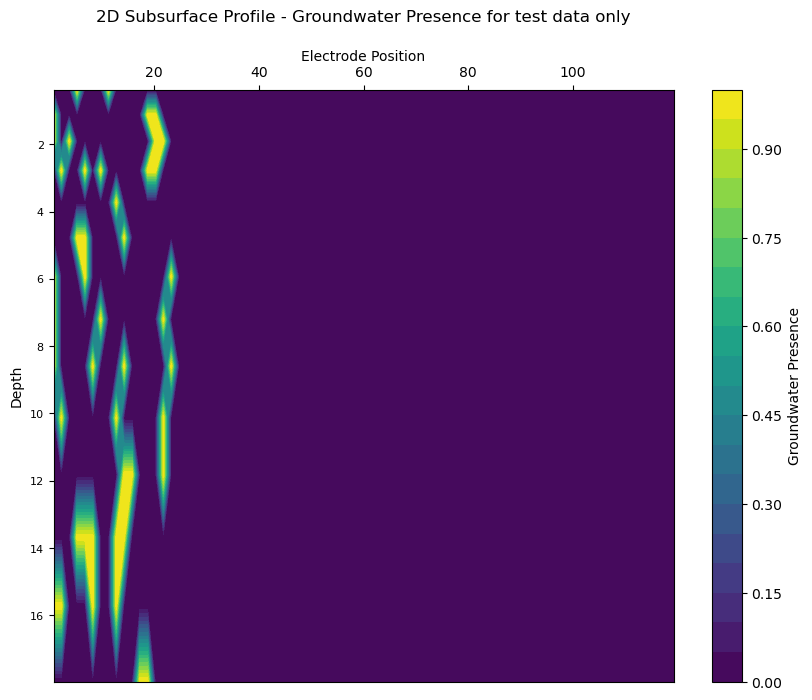

In [19]:
plt.figure(figsize=(10, 8))  # Adjust the figsize as needed

contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Groundwater Presence')
plt.ylabel('Depth')  # Set the y-axis label as usual
plt.gca().invert_yaxis()  # Flip y-axis to match typical subsurface profiles

# Set the title with adjusted position
plt.title('2D Subsurface Profile - Groundwater Presence for test data only', pad=20)

# Move the x-axis label to the top
plt.xlabel('Electrode Position')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# Adjust the y-axis tick parameters to reduce padding and font size
plt.yticks(fontsize=8)  # Adjust the font size as needed

# Adjust the layout with extra space between title and x-axis label
plt.subplots_adjust(top=0.85)  # Adjust the value as needed

plt.savefig('2d_subsurface_test_data.png')  # Save with tight layout
plt.show()

# Step 9. Prediction and visualization using all data

In [20]:
elec_pos_values = np.unique(raw_data['elec_pos'])
depth_values = np.unique(raw_data['depth'])
X, Y = np.meshgrid(elec_pos_values, depth_values)

y_presence_pred_all = best_model_presence.predict(data.drop(["groundwater_presence"], axis=1)) # Predict groundwater presence using the trained model

# Reshape the data for visualization
Z = np.zeros(X.shape)  
index = 0
for i, elec_pos in enumerate(elec_pos_values):
    for j, depth in enumerate(depth_values):
        if index < len(y_presence_pred_all):
            Z[j, i] = y_presence_pred_all[index]
        index += 1
        if index >= len(y_presence_pred_all):
            break

Create the contour plot

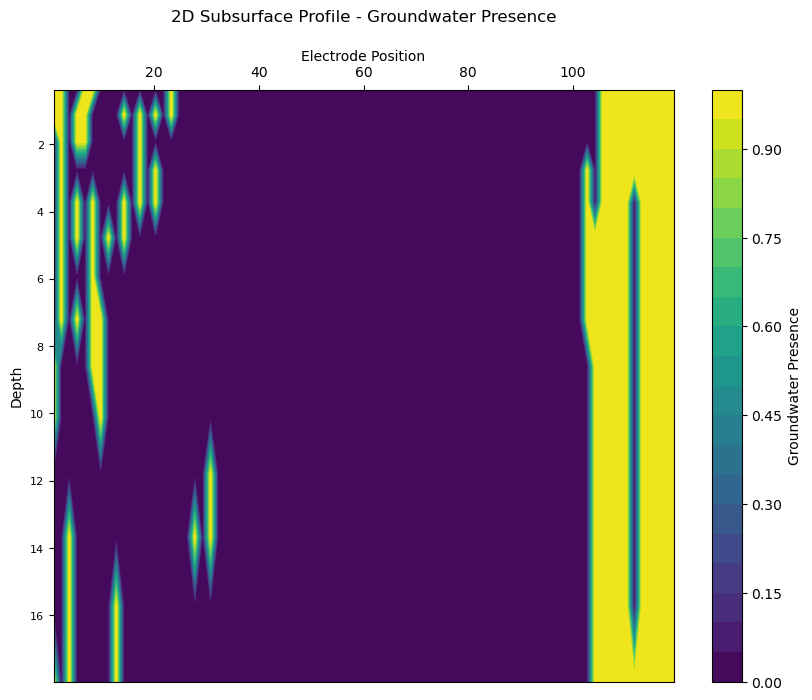

In [21]:
plt.figure(figsize=(10, 8))  # Adjust the figsize as needed
contour = plt.contourf(X, Y, Z, levels=20, cmap='viridis')
plt.colorbar(contour, label='Groundwater Presence')
plt.ylabel('Depth')  # Set the y-axis label as usual
plt.gca().invert_yaxis()  # Flip y-axis to match typical subsurface profiles

# Set the title with adjusted position
plt.title('2D Subsurface Profile - Groundwater Presence', pad=20)

# Move the x-axis label to the top
plt.xlabel('Electrode Position')
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

# Adjust the y-axis tick parameters to reduce padding and font size
plt.yticks(fontsize=8)  # Adjust the font size as needed

# Adjust the layout with extra space between title and x-axis label
plt.subplots_adjust(top=0.85)  # Adjust the value as needed

plt.savefig('2d_subsurface_profile_presence.png')  # Save with tight layout
plt.show()

# Step 10. Save trained model

In [22]:
import pickle

# Save the trained model
model_file = 'Trained_model.pkl'  # Replace with your desired filename
with open(model_file, 'wb') as model_pkl:
    pickle.dump(best_model_presence, model_pkl)

# Model deployment (optional)

In [ ]:
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json  # Assuming you send JSON data with x, y, and rho values
    prediction_presence = best_model_presence.predict([data])[0]
    response = {'groundwater_presence_prediction': 'Yes' if prediction_presence == 1 else 'No'}
    return jsonify(response)

if __name__ == '__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
